# Dataset

In [1]:
import os
import spectral
import numpy as np
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader, Subset
from dataset import HSIDataset

path = '../../home/ivan/HELICoiD/HSI_Human_Brain_Database_IEEE_Access/'

dataset = HSIDataset(path)
dataset.normalize_dataset()

train_indices = list(range(0, 19))
val_indices = list(range(19, 24))
test_indices = list(range(24, 36))

trainset = Subset(dataset, train_indices)
valset = Subset(dataset, val_indices)
testset = Subset(dataset, test_indices)

trainloader = DataLoader(trainset, batch_size=2, shuffle=False)
validationloader = DataLoader(valset, batch_size=2, shuffle=False)
testloader = DataLoader(testset, batch_size=2, shuffle=False)

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualize Data

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


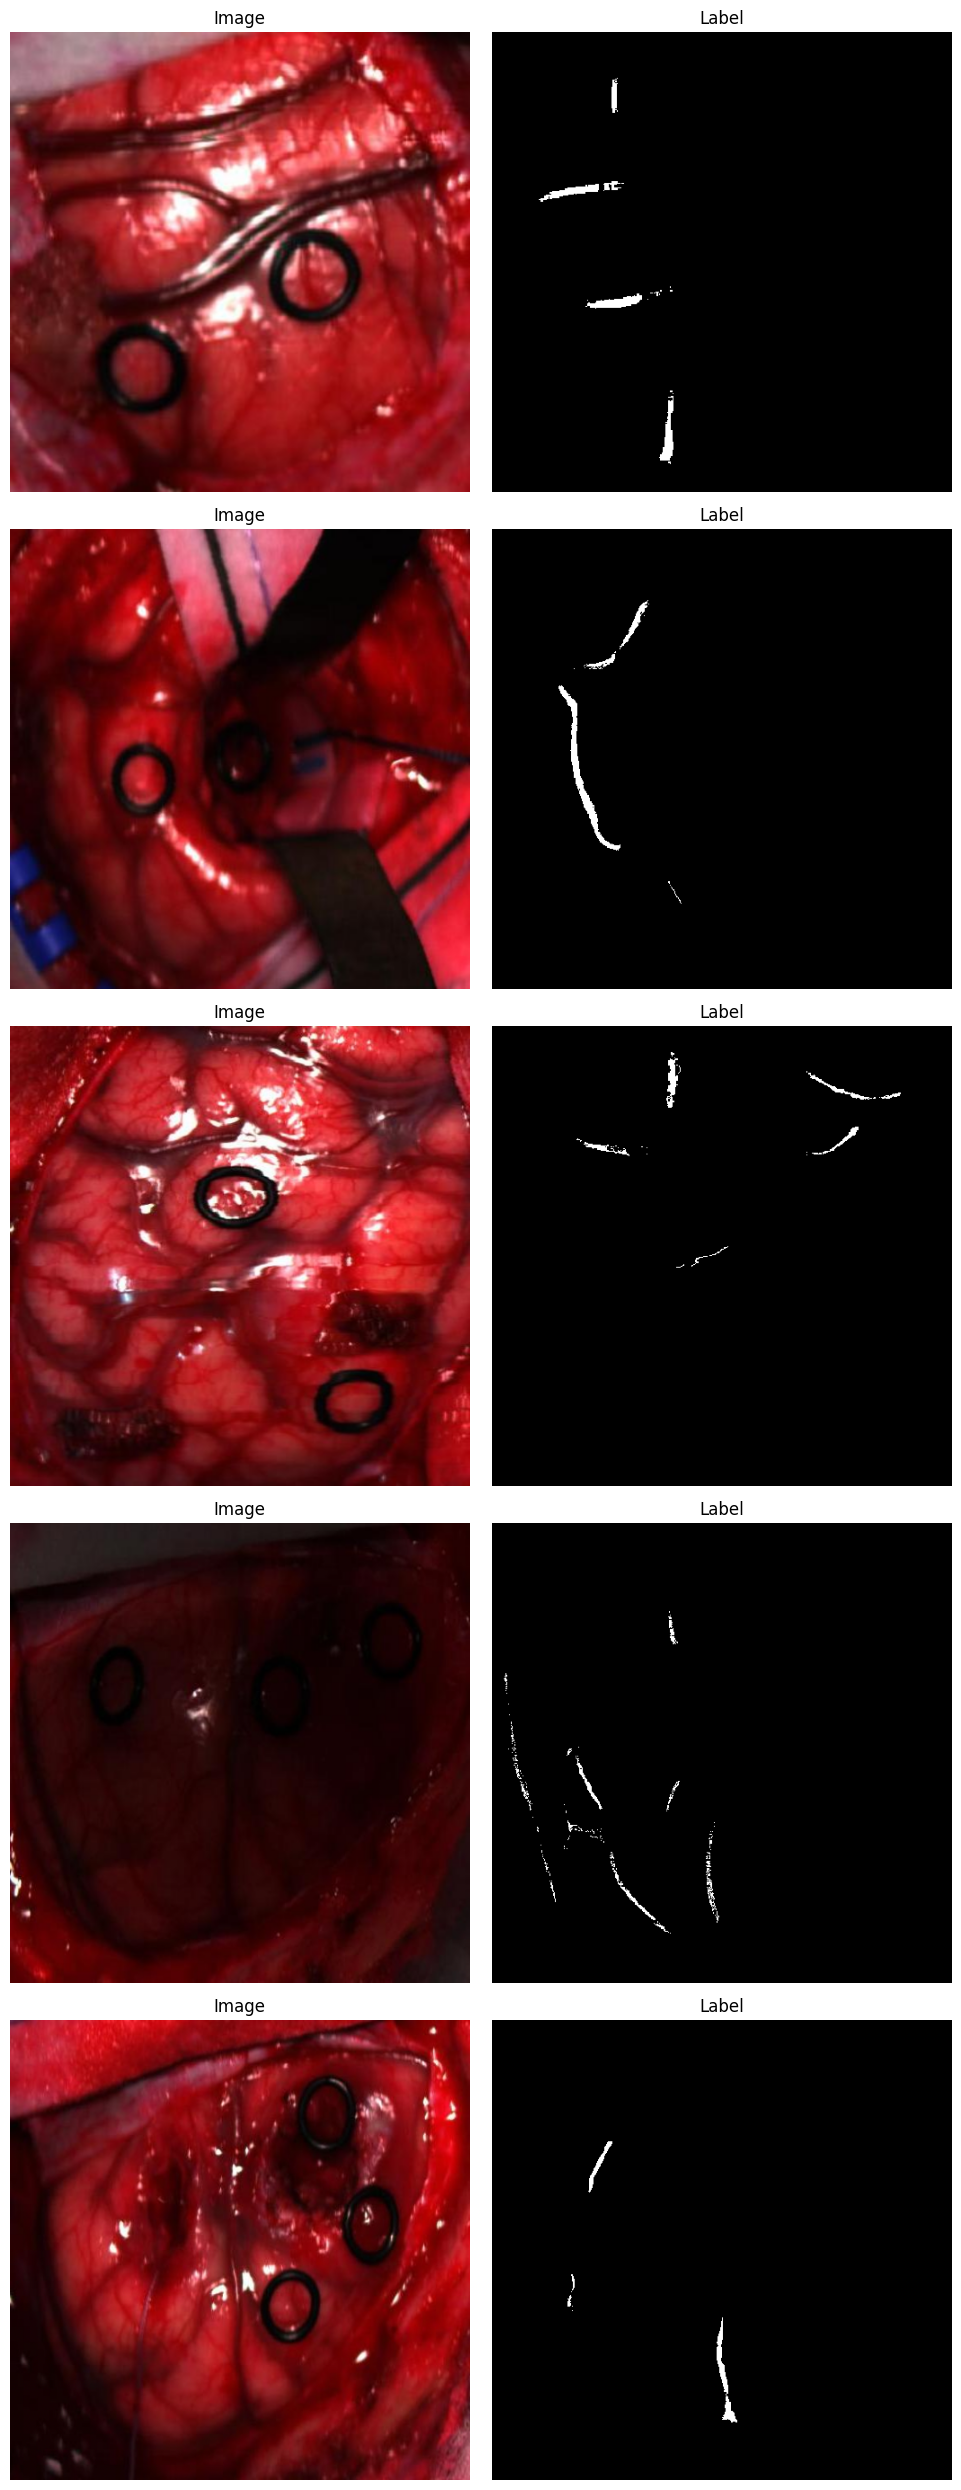

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show_labels(labels):
    plt.imshow(labels.squeeze().numpy(), cmap='gray')
    plt.show()

def create_montage(dataset, num_images=10):
    # Define the number of images you want to show in the montage
    num_images = min(num_images, len(dataset))

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
    for i in range(num_images):
        sample = dataset[i]
        image, label = sample[2], sample[1]
        
        # Convert image and label to numpy arrays for plotting
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
        if isinstance(label, torch.Tensor):
            label = label.numpy().squeeze()
            overlay = np.zeros_like(image)
            overlay[label == 1] = [0, 255, 0]
        
        # Plot the image
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')
        
        # Plot the label
        axes[i, 1].imshow(label, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Label')
    
    plt.tight_layout()
    plt.show()

create_montage(trainset, num_images=5)

# Model Initialization

In [ ]:
import wandb
wandb.login()

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
from segmentation_util import model_pipeline
import torch.nn.functional as F
from HSI_Net import HyperspectralToGrayscale, CombinedModel, ConvolutionalReducer, Unet

config = {
    'model': 'Test-model',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': 1,
    'optimizer': 'Adam',
    'criterion': 'BCELoss',
}

segmenter = smp.Unet('resnet34', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/Unet-resnet34-DiceLoss/Unet-resnet34-DiceLoss_epoch10.pth'))
encoder = HyperspectralToGrayscale()
model = CombinedModel(encoder, segmenter)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Training

In [ ]:
import matplotlib.pyplot as plt
from segmentation_util import model_pipeline


model, train_losses, val_losses = model_pipeline(model, trainloader=trainloader, 
                                                 validationloader=validationloader, 
                                                 testloader=testloader, criterion=criterion, 
                                                 optimizer=optimizer,project='hsi-segmentation',
                                                 model_name=config['model'],
                                                 device=device, config=config, 
                                                 batch_print=1)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


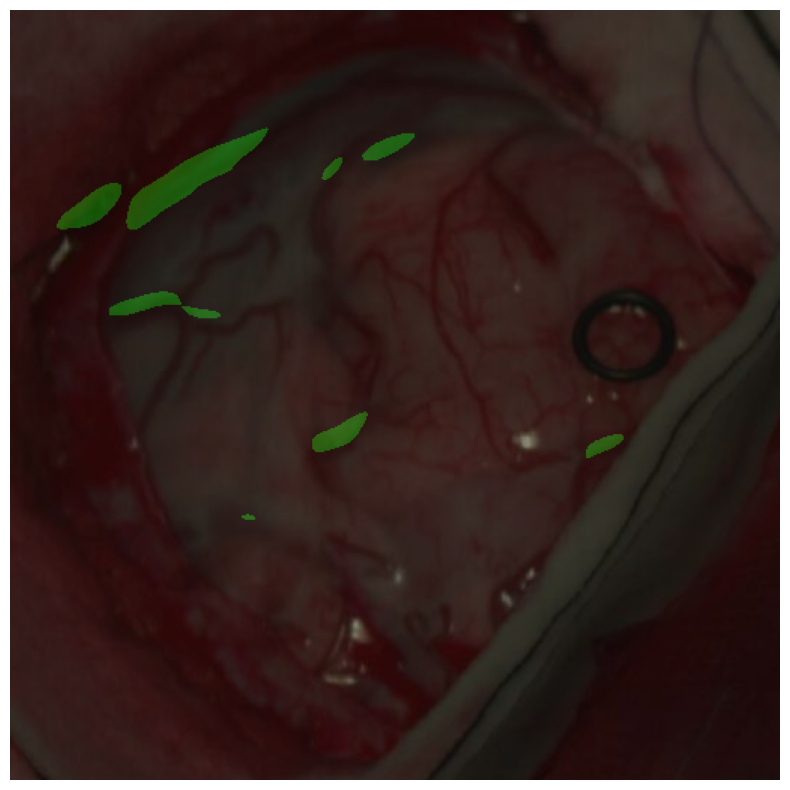

In [2]:
import torch
from HSI_Net import CombinedModel, HyperspectralToGrayscale, ConvolutionalReducer
from segmentation_util import predict, show_overlay
import segmentation_models_pytorch as smp
import cv2
import numpy as np
import matplotlib.pyplot as plt

encoder = HyperspectralToGrayscale()
segmenter = smp.Unet('resnet34', in_channels=1, classes=1)
# segmenter.load_state_dict(torch.load('./models/Unet-resnet34-DiceLoss/Unet-resnet34-DiceLoss_epoch10.pth'))
model = CombinedModel(encoder, segmenter)
model.load_state_dict(torch.load('./models/ConvLayer-Unet-resnet34/ConvLayer-Unet-resnet34_epoch10.pth'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

show_overlay(model, testset[0], device)

# Autoencoder Approach:

In [2]:
from autoencoder import model_pipeline_autoencoder, Autoencoder
import torch.nn as nn


    
config = {
    'model': 'autoencoder',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': 2,
    'optimizer': 'Adam',
    'criterion': 'MSELoss',
}

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

autoencoder, train_losses, val_losses = model_pipeline_autoencoder(autoencoder,
                                                trainloader=trainloader, 
                                                validationloader=validationloader, 
                                                criterion=criterion, 
                                                optimizer=optimizer,
                                                project='hsi-autoencoder',
                                                model_name=config['model'],
                                                device=device, 
                                                config=config, 
                                                batch_print=1)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Epoch 1, Batch 1, Loss: 0.4430
Epoch 1, Batch 2, Loss: 3.7160
Epoch 1, Batch 3, Loss: 0.8628
Epoch 1, Batch 4, Loss: 0.2238
Epoch 1, Batch 5, Loss: 2.3700
Epoch 1, Batch 6, Loss: 0.9442
Epoch 1, Batch 7, Loss: 0.8632
Epoch 1, Batch 8, Loss: 0.2581
Epoch 1, Batch 9, Loss: 0.1346
Epoch 1, Batch 10, Loss: 0.1365
Epoch 1, Train Loss: 0.9952


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Epoch 1, Validation Loss: 0.1548
Epoch 2, Batch 1, Loss: 0.1749
Epoch 2, Batch 2, Loss: 0.1549
Epoch 2, Batch 3, Loss: 0.1720
Epoch 2, Batch 4, Loss: 0.1660
Epoch 2, Batch 5, Loss: 0.1530
Epoch 2, Batch 6, Loss: 0.1221
Epoch 2, Batch 7, Loss: 0.1418
Epoch 2, Batch 8, Loss: 0.1148
Epoch 2, Batch 9, Loss: 0.1000
Epoch 2, Batch 10, Loss: 0.1082
Epoch 2, Train Loss: 0.1408
Epoch 2, Validation Loss: 0.0639
Epoch 3, Batch 1, Loss: 0.2057
Epoch 3, Batch 2, Loss: 0.1681
Epoch 3, Batch 3, Loss: 0.0914
Epoch 3, Batch 4, Loss: 0.0955
Epoch 3, Batch 5, Loss: 0.0698
Epoch 3, Batch 6, Loss: 0.0434
Epoch 3, Batch 7, Loss: 0.0523
Epoch 3, Batch 8, Loss: 0.0490
Epoch 3, Batch 9, Loss: 0.0387
Epoch 3, Batch 10, Loss: 0.0436
Epoch 3, Train Loss: 0.0858
Epoch 3, Validation Loss: 0.1279
Epoch 4, Batch 1, Loss: 0.0710
Epoch 4, Batch 2, Loss: 0.0363
Epoch 4, Batch 3, Loss: 0.0325
Epoch 4, Batch 4, Loss: 0.0260
Epoch 4, Batch 5, Loss: 0.0231
Epoch 4, Batch 6, Loss: 0.0192
Epoch 4, Batch 7, Loss: 0.0210
Epoch 

epoch,▁▂▃▃▄▅▆▆▇█
train/loss,█▂▁▁▁▁▁▁▁▁
validation/loss,█▂▆▁▁▁▁▁▂▂
epoch,10
train/loss,0.0212
validation/loss,0.05302


/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


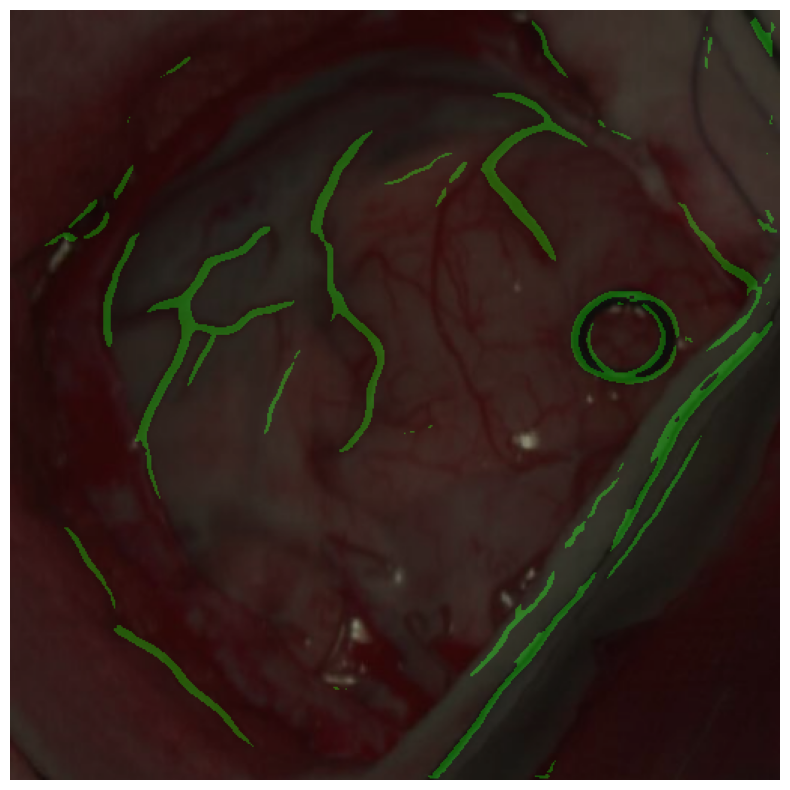

In [8]:
from HSI_Net import CombinedModel
from segmentation_util import predict, show_overlay
from autoencoder import Autoencoder
import segmentation_models_pytorch as smp

autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('./models/autoencoder_epoch10.pth'))
segmenter = smp.Unet('resnet101', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/Unet-Resnet101-512x512_epoch10.pth'))
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

model = CombinedModel(autoencoder.encoder, segmenter)
show_overlay(model, testset[0], device)
# autoencoder = Autoencoder()
# autoencoder.load_state_dict(torch.load('./models/autoencoder_epoch8.pth'))